In [1]:
from typing import Tuple, Dict

import h5py
import pandas as pd
import numpy as np
from joblib import load, dump
from umap import UMAP
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use("publication")

In [2]:
def standardize_test(estimator: "sklearn model", search_params: Tuple[Dict], data: Tuple[np.ndarray, np.ndarray]):
    # split data into X and y for regression
    X, y = data
    # Manually specify 10-fold cross-validation for the grid search
    kfold = KFold(10, random_state=42, shuffle=True)
    grid_search = GridSearchCV(
        estimator, search_params, scoring="neg_mean_squared_error", cv=kfold, n_jobs=4
    )
    # run the grid search
    grid_search.fit(X, y)
    # give some summary statistics
    y_mask = y != 0.
    y_pred = grid_search.best_estimator_.predict(X)
    mse = metrics.mean_squared_error(y_pred, y)
    masked_mse = metrics.mean_squared_error(y_pred[y_mask], y[y_mask])
    print(f"Best MSE: {mse:.4f}")
    print(f"Best masked MSE: {masked_mse:.4f}")
    return grid_search, grid_search.best_estimator_

## Setting molecules with no chance of observing to zero column

In [3]:
data = h5py.File("../../data/processed/smiles_embeddings_300.h5", "r")

In [4]:
data.keys()

<KeysViewHDF5 ['cluster_ids', 'pca', 'smiles', 'vectors']>

In [5]:
pipeline = load("../../models/embedding_pipeline.pkl")
pca = load("../../models/pca_model.pkl")

In [6]:
tmc1_df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

# tmc1_df = tmc1_df.loc[tmc1_df["Formula"] != "H2"]

tmc1_df.reset_index(inplace=True, drop=True)

In [7]:
tmc1_vecs = np.vstack(tmc1_df["Vecs"])

In [8]:
# Here we purposefully withdraw some classes of molecules to see
# how well these are reproduced
holdout_df = tmc1_df.loc[~tmc1_df["Formula"].isin(["HC5N", "HC9N", "CH3C4H"])]

In [9]:
holdout_vecs = np.vstack(holdout_df["Vecs"])

In [10]:
pipeline

Pipeline(steps=[('incrementalpca', IncrementalPCA(n_components=100)),
                ('kmeans', KMeans(n_clusters=20, random_state=42))])

In [11]:
tmc1_cluster_ids = pipeline.predict(tmc1_vecs)
holdout_cluster_ids = pipeline.predict(holdout_vecs)

In [12]:
tmc1_embedding = pipeline.steps[0][1].transform(tmc1_vecs)
holdout_embedding = pipeline.steps[0][1].transform(holdout_vecs)

In [13]:
holdout_y = np.log10(holdout_df["Column density (cm^-2)"].to_numpy())

## Prepping data

In [14]:
indices = np.arange(len(data["pca"]))

rng = np.random.default_rng(42)

mask = np.zeros_like(data["cluster_ids"], dtype=bool)
for i in np.unique(tmc1_cluster_ids):
    mask += data["cluster_ids"][:] == i

In [15]:
# Extract out the molecules contained within our cluster
all_pca = (data["pca"][:])[mask,:]
subset_smiles = (data["smiles"][:])[mask]

In [16]:
X = tmc1_embedding
Y = tmc1_df["Column density (cm^-2)"].to_numpy()
Y = np.log10(Y)
shift = Y.mean()
# Y -= shift

In [17]:
# calculate pairwise distances between TMC-1 molecules and all others
distances = cosine_distances(tmc1_embedding, all_pca)

In [18]:
dist_mask = distances.mean(axis=0) > 0.6

In [19]:
# this counts the number of molecules we're artificially constraining
dist_mask.sum()

69

### What molecules are we setting to zero?

You can expand the cell below to see SMILES for the molecules we're zeroing

In [20]:
subset_smiles[dist_mask]

array(['NC(=O)CC(F)(F)C(F)(F)F', 'OC1C=CC(C=C1)=C1N=C=CC=N1',
       'O=C(C#CC(F)(F)F)C(F)(F)F', 'OC(F)(C(F)(F)F)C(F)(F)F',
       'CN(CCN=[N+]=[N-])CCN=[N+]=[N-]', 'OC(F)(F)C(F)(F)C(F)(F)F',
       'ON=C(C(F)(F)F)C(F)(F)F', 'CCC(O)C(F)(F)C(F)(F)F',
       'CC(O)(C(F)(F)F)C(F)(F)F', 'OCC(F)(F)C(F)(F)C(F)F',
       'OCC(F)(F)C(F)C(F)(F)F', 'O=C(C(F)(F)F)C(F)(F)F',
       'CC(C)(O)C(F)(F)C(F)(F)F', 'NC(CC(F)(F)F)C(F)(F)F',
       'FC(F)(F)CNCC(F)(F)F', 'CC(N)COC(F)(F)C(F)(F)F',
       'NCCCOC(F)(F)C(F)(F)F', 'NCCOCC(F)(F)C(F)(F)F',
       'FC(C(F)(F)F)C(F)(F)F', 'FC(F)C(F)(F)C(F)(F)F',
       'FC(F)(F)COCC(F)(F)F', 'COC(C(F)(F)F)C(F)(F)F',
       'FC(F)OCC(F)(F)C(F)F', 'NCCC(C(F)(F)F)C(F)(F)F',
       'CCOCC(F)(F)C(F)(F)F', 'FC(F)(F)COC(F)(F)F',
       'CC(C)(C)CN=c1[nH]c(=N)[nH]c(=N)[nH]1',
       'CC(C)=CCN=c1[nH]c(=N)[nH]c(=N)[nH]1',
       'CCC=CCN=c1[nH]c(=N)[nH]c(=N)[nH]1',
       'C=CCC(C)N=c1[nH]c(=N)[nH]c(=N)[nH]1',
       'C=CCCCN=c1[nH]c(=N)[nH]c(=N)[nH]1',
       'C=C(C)CCN=c

In [21]:
dummies = all_pca[dist_mask]
dummy_y = np.zeros(len(dummies))

In [22]:
# add the constrained values to our training data
train_x = np.vstack([X, dummies])
train_y = np.hstack([Y, dummy_y])

In [23]:
holdout_train_x = np.vstack([holdout_embedding, dummies])
holdout_train_y = np.hstack([holdout_y, dummy_y])

## Linear regression

In [24]:
linear_tuning = [{"normalize": [True, False], "fit_intercept": [True, False]}]

In [25]:
linear_grid, linear_model = standardize_test(LinearRegression(), linear_tuning, (train_x, train_y))

Best MSE: 0.6048
Best masked MSE: 1.0555


In [26]:
linear_cols = linear_model.predict(all_pca)

## Support vector machines

In [27]:
svm_search, svm_model = standardize_test(
    SVR(), [{"kernel": ["linear", "rbf", "poly"], "degree": [2, 3, 4, 5], "C": np.linspace(0.2, 2., 10)}], (train_x, train_y)
)

Best MSE: 0.7793
Best masked MSE: 1.4017


In [28]:
dump(svm_search, "../../models/svm_grid.pkl")

['../../models/svm_grid.pkl']

In [29]:
svm_cols = svm_model.predict(all_pca)

## $k$-nearest neighbors

In [30]:
knn_search, knn = standardize_test(
    KNeighborsRegressor(algorithm="brute"),
    [{"n_neighbors": [2, 4, 5, 6, 8, 10, 15, 30, 50, 100], "metric": ["cosine", "euclidean"]}],
    (train_x, train_y)
)

Best MSE: 0.6915
Best masked MSE: 0.8418


In [31]:
knn_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 2}

In [32]:
# predict column densities with k-NN
knn_cols = knn.predict(all_pca)

In [33]:
dump(knn_search, "../../models/knn_grid.pkl")

['../../models/knn_grid.pkl']

## Ensemble methods

### Random Forest regression

In [34]:
gbr_tuning = [{"learning_rate": 10**np.linspace(-3., 1., 5), "n_estimators": [20, 50, 80, 100, 125, 150, 200], "subsample": np.linspace(0.1, 1., 5)}]
rfr_tuning = [{"n_estimators": [20, 50, 80, 100, 125, 150, 200]}]

In [35]:
rfr_search, rfr = standardize_test(
    RandomForestRegressor(), rfr_tuning, (train_x, train_y)
)

Best MSE: 0.2789
Best masked MSE: 0.4017


### Gradient boosting

In [36]:
gbr_search, gbr = standardize_test(
    GradientBoostingRegressor(), gbr_tuning, (train_x, train_y)
)

Best MSE: 0.1989
Best masked MSE: 0.2589


/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [37]:
rfr_cols, gbr_cols = rfr.predict(all_pca), gbr.predict(all_pca)

In [38]:
dump(gbr_search, "../../models/gradient_boosting_grid.pkl")
dump(rfr_search, "../../models/random_forest_grid.pkl")

['../../models/random_forest_grid.pkl']

### Testing gradient boosting with custom holdout

In [39]:
holdout_gbr_search, holdout_gbr = standardize_test(
    GradientBoostingRegressor(), gbr_tuning, (holdout_train_x, holdout_train_y)
)

Best MSE: 0.3588
Best masked MSE: 0.5306


/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,
/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


In [40]:
tmc1_df["Holdout_GBR"] = holdout_gbr.predict(tmc1_embedding)

In [41]:
dump(holdout_gbr, "../../models/holdout_gradient_boosting.pkl")

['../../models/holdout_gradient_boosting.pkl']

## Gaussian process regression

In [42]:
# This is a poorly designed model; I manually fiddled around with the kernel definition and parameters
# until I got bored, and that the test sccore was reasonable
kernel = kernels.RBF(length_scale_bounds=(1e-3, 1e2)) + kernels.ExpSineSquared(periodicity_bounds=(1e-8, 1e2), length_scale_bounds=(1e-8, 1e2)) * kernels.RBF() + kernels.RationalQuadratic(alpha_bounds=(1e-3, 1e4), length_scale_bounds=(5e1, 1e4))# + kernels.ConstantKernel() * kernels.WhiteKernel()
gp_model = GaussianProcessRegressor(kernel, alpha=0.5, normalize_y=True, random_state=42)

In [43]:
gp_search, gp_model = standardize_test(
    gp_model, [{"alpha": 10**np.linspace(-10., 1., 10)}], (train_x, train_y)
)

Best MSE: 0.0000
Best masked MSE: 0.0001


In [44]:
gp_model.kernel_

RBF(length_scale=86.5) + ExpSineSquared(length_scale=1e-08, periodicity=1e-08) * RBF(length_scale=0.0701) + RationalQuadratic(alpha=1e+04, length_scale=86.5)

In [45]:
gp_cols, gp_std = gp_model.predict(all_pca, return_std=True)
gp_tmc_cols, gp_tmc_cov = gp_model.predict(tmc1_embedding, return_cov=True)

In [46]:
dump(gp_search, "../../models/gp_grid.pkl")

['../../models/gp_grid.pkl']

In [51]:
from palettable.cartocolors.sequential import SunsetDark_4

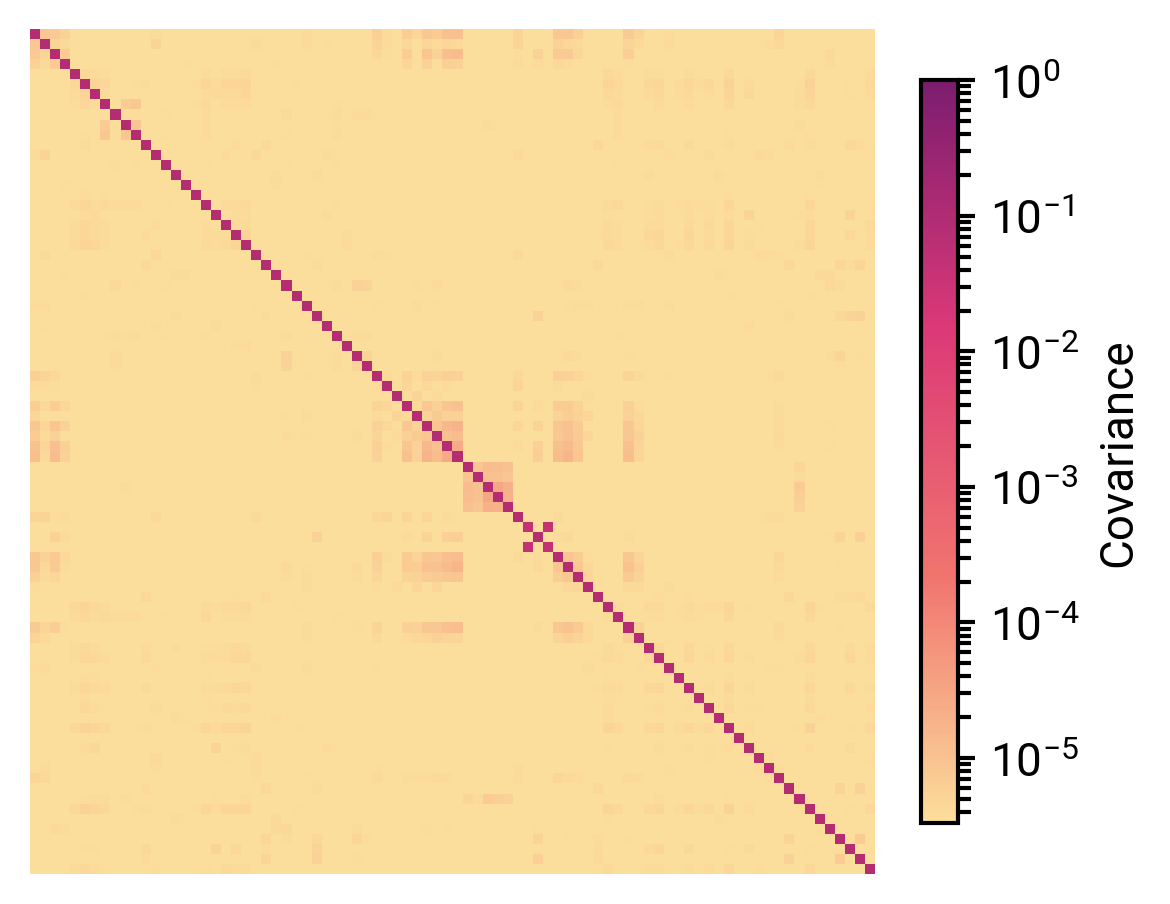

In [59]:
fig, ax = plt.subplots(figsize=(4,4))

hurr = ax.imshow(np.abs(gp_tmc_cov), cmap=SunsetDark_4.get_mpl_colormap(), norm=LogNorm(vmin=np.abs(gp_tmc_cov.min()), vmax=1.))

cb = fig.colorbar(hurr, ax=ax, fraction=0.04)
cb.ax.set_ylabel("Covariance")
ax.set(xticks=[], yticks=[])
for spine in ["left", "bottom"]:
    ax.spines[spine].set_visible(False)

fig.savefig("gp_tmc1_covariance.pdf", dpi=100, transparent=True)
fig.savefig("gp_tmc1_covariance.png", dpi=300, transparent=True)

## UMAP viz

In [100]:
manifold_model = UMAP(n_neighbors=20, random_state=42, metric="cosine")

# train on context of cluster
manifold_model.fit(tmc1_embedding)

UMAP(angular_rp_forest=True, metric='cosine', n_neighbors=20, random_state=42)

In [101]:
# project TMC-1 molecules onto cluster manifold
# tmc1_rep = manifold_model.transform(tmc1_embedding)
all_rep = manifold_model.transform(all_pca)

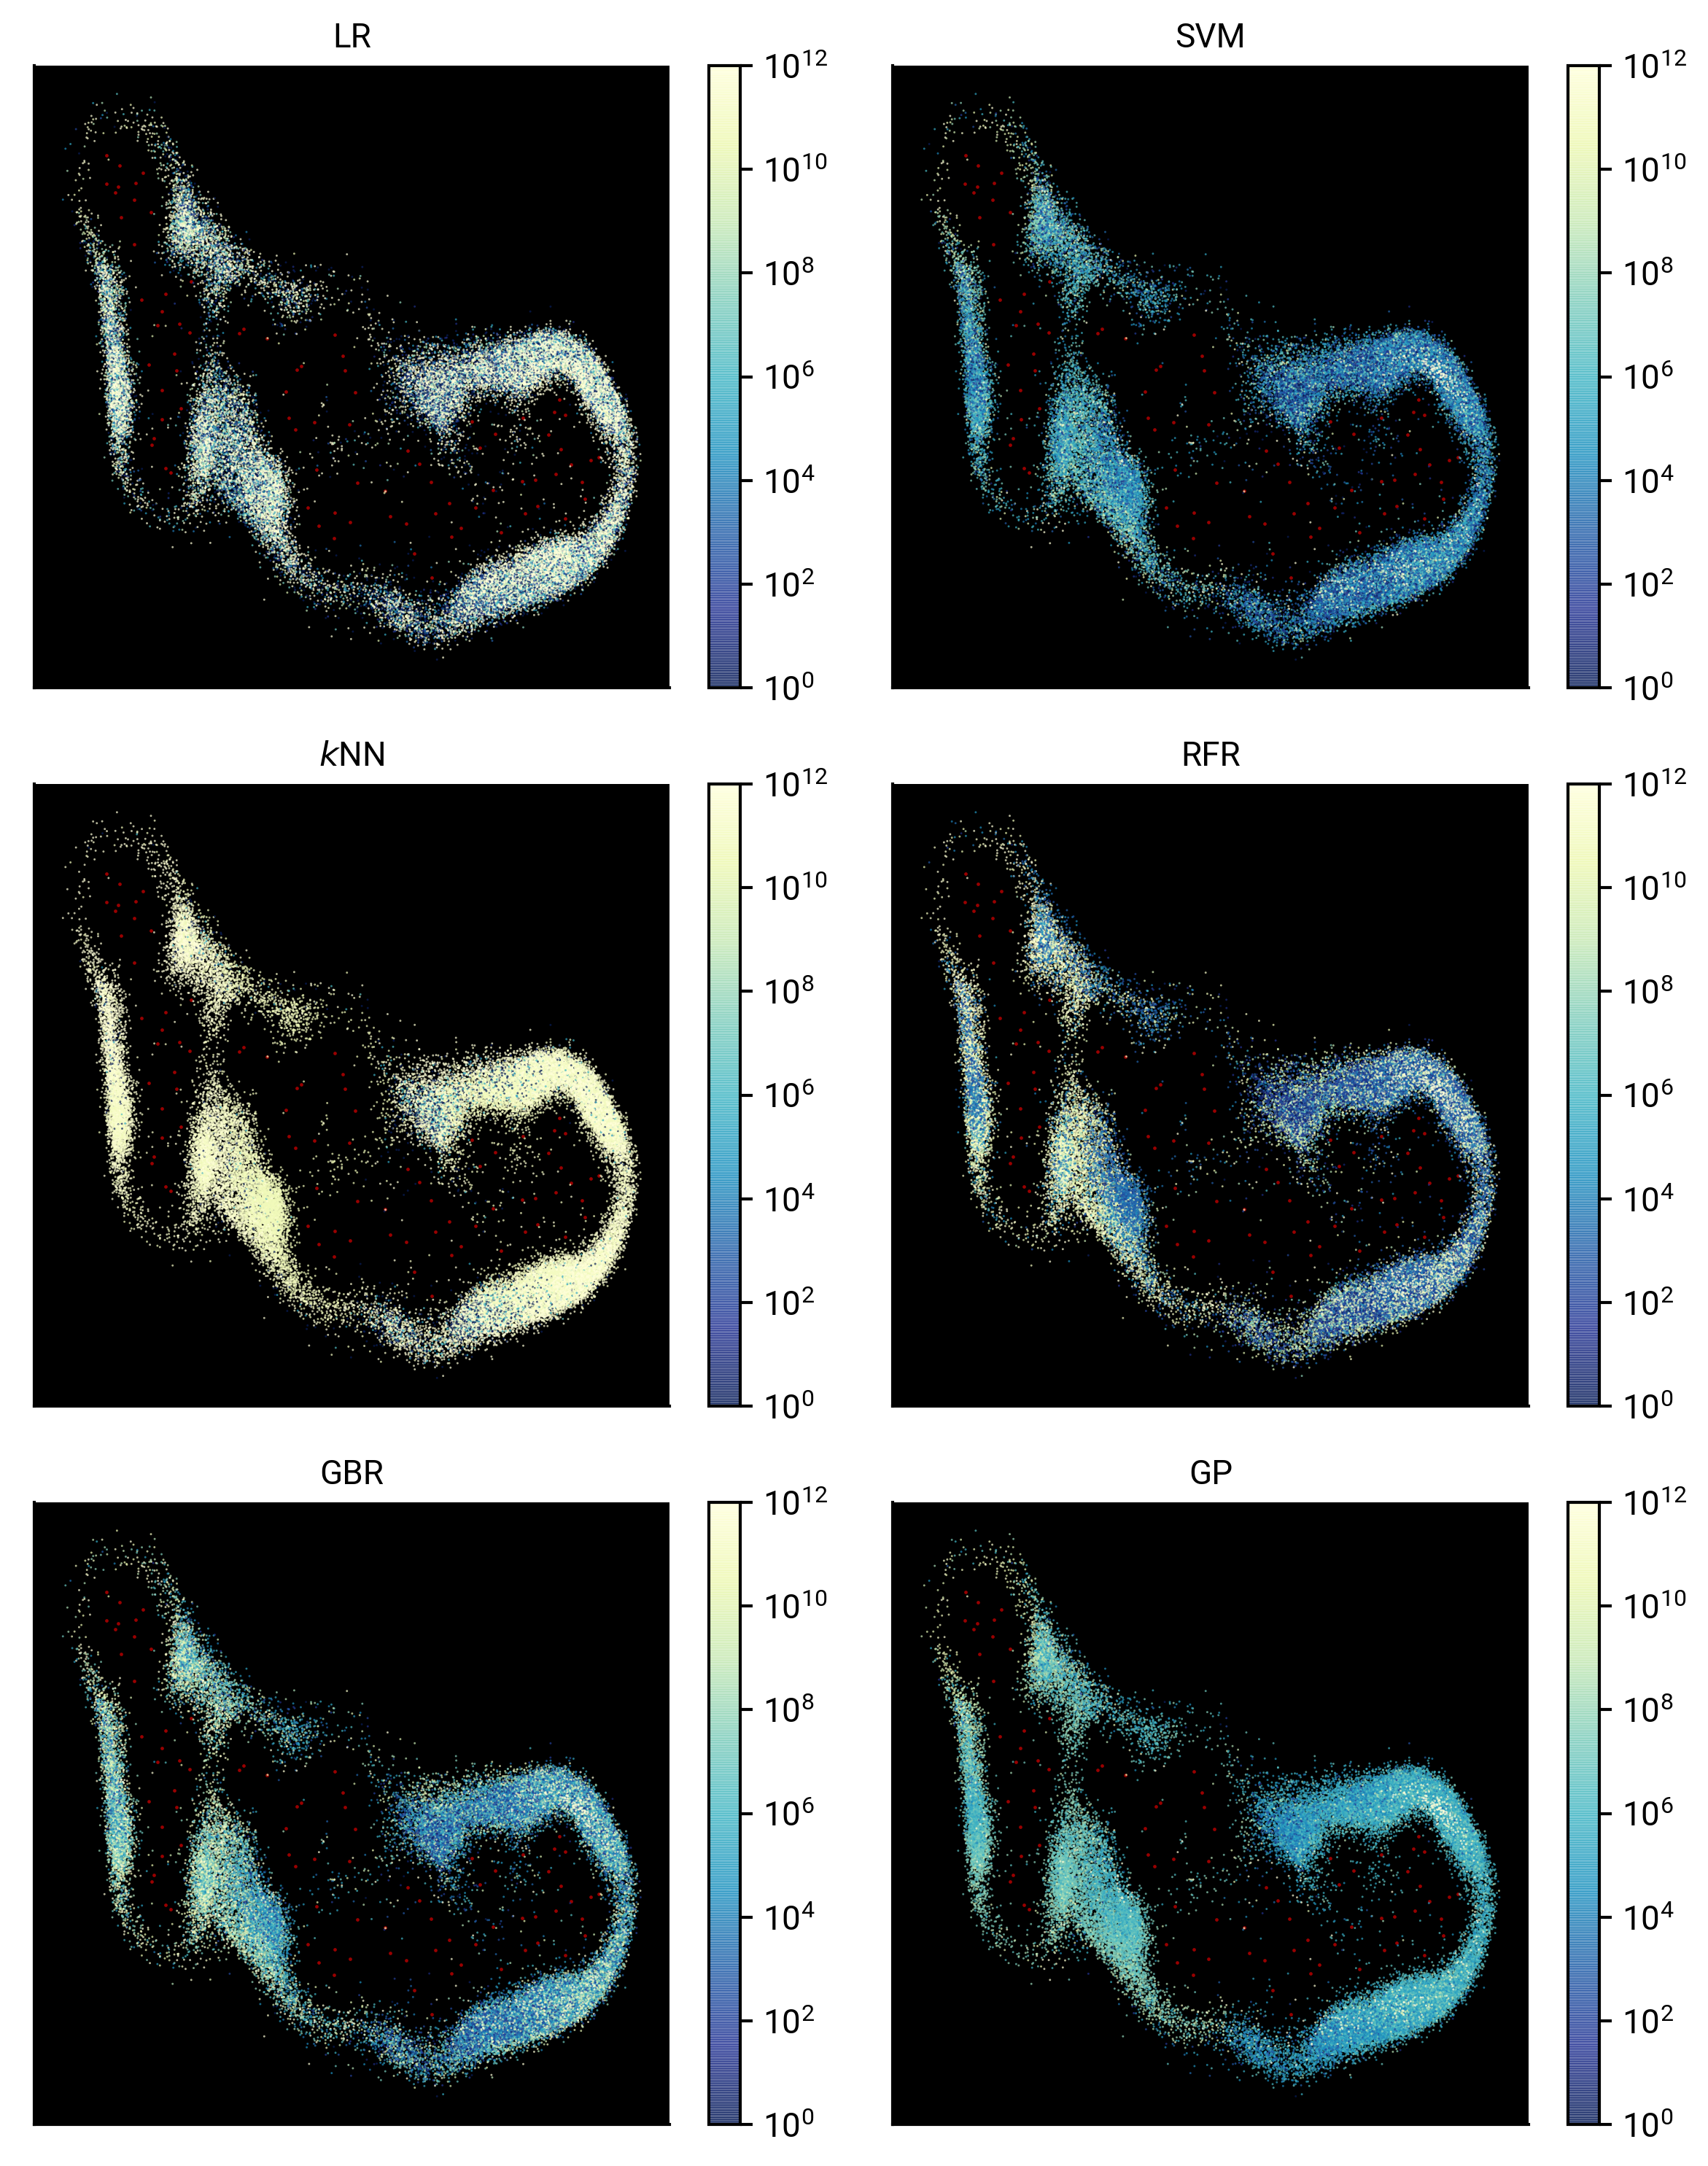

In [102]:
fig, axarray = plt.subplots(3, 2, figsize=(8, 10))

columns = [linear_cols, svm_cols, knn_cols, rfr_cols, gbr_cols, gp_cols]
names = ["LR", "SVM", "$k$NN", "RFR", "GBR", "GP"]

for ax, name, column in zip(axarray.ravel(), names, columns):
    ax.set_facecolor('k')
    ax.scatter(manifold_model.embedding_[:,0], manifold_model.embedding_[:,1], s=1., lw=0.1, alpha=0.6, color="r")
    plot = ax.scatter(all_rep[:,0], all_rep[:,1], s=0.5, c=10**column, cmap="YlGnBu_r", norm=LogNorm(vmin=1., vmax=1e12), alpha=0.7, lw=0.)
#     ax.scatter(manifold_model.embedding_[dist_mask,0], manifold_model.embedding_[dist_mask,1], s=10., marker="x", c="w", alpha=0.4, lw=0.5)
    ax.set(title=name, xticks=[], yticks=[])

    fig.colorbar(plot, ax=ax)
    
# fig.savefig("full_estimator_comparison.png", dpi=300)
# fig.savefig("full_estimator_comparison.pdf", dpi=100)

In [91]:
import plotly.express as px
from plotly import graph_objs as go

In [105]:
names = data["smiles"][:]

In [106]:
fig = go.Figure(
    data=[go.Scattergl(
         x=all_rep[:,0],
         y=all_rep[:,1],
        mode="markers",
        opacity=0.4,
        text=names,
        marker={
            "color": gbr_cols,
            "colorscale": "Viridis",
            "colorbar": dict(thickness=20)
        },
        name="Gradient Boosting"
    ),
         go.Scattergl(
             x=manifold_model.embedding_[:,0],
            y=manifold_model.embedding_[:,1],
             mode="markers",
             opacity=0.9,
             text=tmc1_df["SMILES"],
             name="TMC-1"
         )
         ],
    layout={
        "paper_bgcolor": 'rgba(0,0,0,0)',
        "plot_bgcolor": 'rgba(0,0,0,0)',
        "xaxis": {"zeroline": False, "showline": False, "mirror": True},
        "yaxis": {"zeroline": False, "showline": False, "mirror": True}
    }
)

In [107]:
fig.write_html("interactive-all-predict.html", include_plotlyjs="cdn")